In [18]:
##################### CODE DIFFERENCE UTILITY #####################
import code_diff as cd

from code_diff.gumtree import ops

def _subtrees(script):
    subtrees = {}
    for action in script:
        if not isinstance(action, (ops.Insert, ops.Move)): continue
        target, node, position = action.target_node, action.node, action.position

        if isinstance(action, ops.Insert):
            _, text = node
            insert_content = text if text is not None else action.insert_id
            if isinstance(insert_content, int):
                continue
            subtrees[action.insert_id] = (insert_content)
            # target_id = target.node_id
            # if target_id not in subtrees: subtrees[target_id] = []
            # else: subtrees[target_id] = []
            # subtrees[target_id].insert(position, insert_content)
        elif isinstance(action, ops.Move):
            insert_content = node
            # subtrees[str(action.move_id)] = (insert_content)

        # if hasattr(target, "node_id"):
        #     target_id = target.node_id
        #     if target_id not in subtrees: subtrees[target_id] = []
        #     else: subtrees[target_id] = []
        #     subtrees[target_id].insert(position, insert_content)
    
    return subtrees

def _serialize_tree(subtrees, node_id):
    result = []
    stack  = [node_id]

    while len(stack) > 0:
        element = stack.pop(0)
        if isinstance(element, int):
            # element = str(element)
            elem = subtrees.get(element, [])
            if (elem != []):
                result.append(elem)
            else:
                stack = subtrees.get(element, []) + stack
        else:
            result.append(element)

    return result

def flatten_script(script):
    result_script = []
    subtrees = _subtrees(script)

    for action in script:
        if isinstance(action, ops.Insert):
            # if not hasattr(action.target_node, "node_id"): continue # Ignore because we flatten
            new_node = _serialize_tree(subtrees, action.insert_id)
            result_script.append(ops.Insert(action.target_node, new_node, position = action.position, insert_id=action.insert_id))
        elif isinstance(action, ops.Move) and hasattr(action.target_node, "node_id"):
            result_script.append(ops.Delete(action.node))
        else:
            result_script.append(action)

    return result_script


def synthesize_rewrite_script(script):
    # Flatten the script: Build and parse the subtrees that are inserted or moved
    flat_script = flatten_script(script)
    # Generate new actions of the form (replace_span, token_seq)
    # You can transform the source by replacing each span with the token sequence 
    result = []
    for action in flat_script:
        target_node = action.target_node
        if isinstance(action, ops.Insert):
            # if action.position == len(target_node.children):
            target = target_node
            while (target.children == []):
                target = target.parent
            # if (target_node.children == []): 
            #     predecessor = target_node.parent
            #     (start_line, start_pos), (end_line, end_pos) = predecessor.position[1], predecessor.position[1]
            # else:
            predecessor = target
            (start_line, start_pos), (end_line, end_pos) = predecessor.position[1], predecessor.position[1]
            
            # else:
            #     if (target_node.children == []): # what I want is the line number only not column offset
            #         predecessor = target_node.parent
            #         (start_line, start_pos), (end_line, end_pos) = predecessor.position[1], predecessor.position[1]
            #     else:
            #         predecessor = target_node.children[action.position]
            #         (start_line, start_pos), (end_line, end_pos) = predecessor.position[1], predecessor.position[1]
            if (action.node == []): continue
            parent = target_node.parent
            while parent and parent.__class__.__name__ != 'ASTNode':
                # print(parent.__class__.__name__)
                parent = parent.parent

            # print(parent.type)
            insertOperation = f'[Insert]: [{target_node.type}] {action.node}: parent [{parent.type}]'
            # print(target_node.__class__.__name__)
            result.append(((start_line, start_pos, end_line, end_pos), [insertOperation]))
        elif isinstance(action, ops.Update):
            (start_line, start_pos), (end_line, end_pos) = target_node.position
            updateOperation = f'[Update]: [{(target_node).type}] from [{target_node.text}] to [{action.value}]'

            result.append(((start_line, start_pos, end_line, end_pos), [updateOperation]))
        elif isinstance(action, ops.Delete):
            (start_line, start_pos), (end_line, end_pos) = target_node.position
            deleteOperation = f'[Delete]: [{(target_node).type}] [{target_node.parent.type}]'
            result.append(((start_line, start_pos, end_line, end_pos), [deleteOperation]))
    return result

###################################################################################


In [19]:
output = cd.difference(
    '''
        expected = datetime . datetime ( 1970 , 1 , 1 , 1 , 0 , 23 , 0 , datefmt . localtz )
    ''',
    '''
        expected = datetime . datetime . fromtimestamp ( 23 , datefmt . localtz )
    ''',
lang = "python")



s = output.edit_script()
# s = synthesize_rewrite_script(s)
# print((s))

# Open the file in write mode
# with open('O:\DriveFiles\GP_Projects\Bug-Repair\Q-A\MyMutpy\output.txt', 'w') as file:
#     for action in s:
#         (start_line, start_pos, end_line, end_pos), new_content = action
#         file.write(f"{start_line} {start_pos} {end_line} {end_pos} {new_content}\n")

import json

def read_json_file(file_path):
    with open(file_path, 'r') as f:
        line_content = [json.loads(line) for line in f.readlines()]
    return line_content
data = read_json_file('ctssb_data_1M/ctssb_data_1M/file-0.jsonl/file-0.jsonl')


import ast

bef = data[10]["before"]
aft = data[10]["after"]

print(bef)
print(aft)
# print(data[1]["comodified"])
# print(data[41]["edit_script"])
# print(data[631]["likely_bug"])

# s = ast.dump(ast.parse(data[31]["after"]), indent=4)
# print(s)
print("-------------------------------------")
b = bef
a = aft

diff = cd.difference(b, a, lang="python")
# print(diff.edit_script())
actions = synthesize_rewrite_script(diff.edit_script())
for action in actions:
    print(action[1])


# print(ast.dump(ast.parse(b), indent=4))

/usr/local/lib/python3.10/dist-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


db_generation = row and row [ 0 ] or - 1
db_generation = not row and - 1 or row [ 0 ]
-------------------------------------
['[Delete]: [boolean_operator] [boolean_operator]']
["[Insert]: [boolean_operator] ['or']: parent [boolean_operator]"]
['[Delete]: [and] [boolean_operator]']
["[Insert]: [boolean_operator] ['- 1']: parent [boolean_operator]"]
["[Insert]: [not_operator] ['not']: parent [boolean_operator]"]
['[Delete]: [identifier] [boolean_operator]']
['[Delete]: [or] [boolean_operator]']
['[Delete]: [unary_operator] [boolean_operator]']


The graph nodes are  <class 'list'> ['n4', 'n6', 'n8', 'n10', 'n14']
n4 n8 {'weight': 2}
n4 n6 {'weight': 10}
n4 n10 {'weight': 7}
n6 n8 {'weight': 4}
n6 n14 {'weight': 4}
n6 n4 {'weight': 10}
n8 n4 {'weight': 2}
n8 n6 {'weight': 4}
n8 n10 {'weight': 6}
n8 n14 {'weight': 5}
n10 n8 {'weight': 6}
n10 n4 {'weight': 7}
n14 n6 {'weight': 4}
n14 n8 {'weight': 5}
n4 n8 {'weight': 2}
n4 n6 {'weight': 10}
n4 n10 {'weight': 7}
n6 n8 {'weight': 4}
n6 n14 {'weight': 4}
n6 n4 {'weight': 10}
n8 n4 {'weight': 2}
n8 n6 {'weight': 4}
n8 n10 {'weight': 6}
n8 n14 {'weight': 5}
n10 n8 {'weight': 6}
n10 n4 {'weight': 7}
n14 n6 {'weight': 4}
n14 n8 {'weight': 5}
List of edges: <class 'dict'> {('n4', 'n8'): 2, ('n4', 'n6'): 10, ('n4', 'n10'): 7, ('n6', 'n8'): 4, ('n6', 'n14'): 4, ('n6', 'n4'): 10, ('n8', 'n4'): 2, ('n8', 'n6'): 4, ('n8', 'n10'): 6, ('n8', 'n14'): 5, ('n10', 'n8'): 6, ('n10', 'n4'): 7, ('n14', 'n6'): 4, ('n14', 'n8'): 5}
Example of function Get_Out_Nodes with node n6 ['n8', 'n14', 'n4']
n4 n8

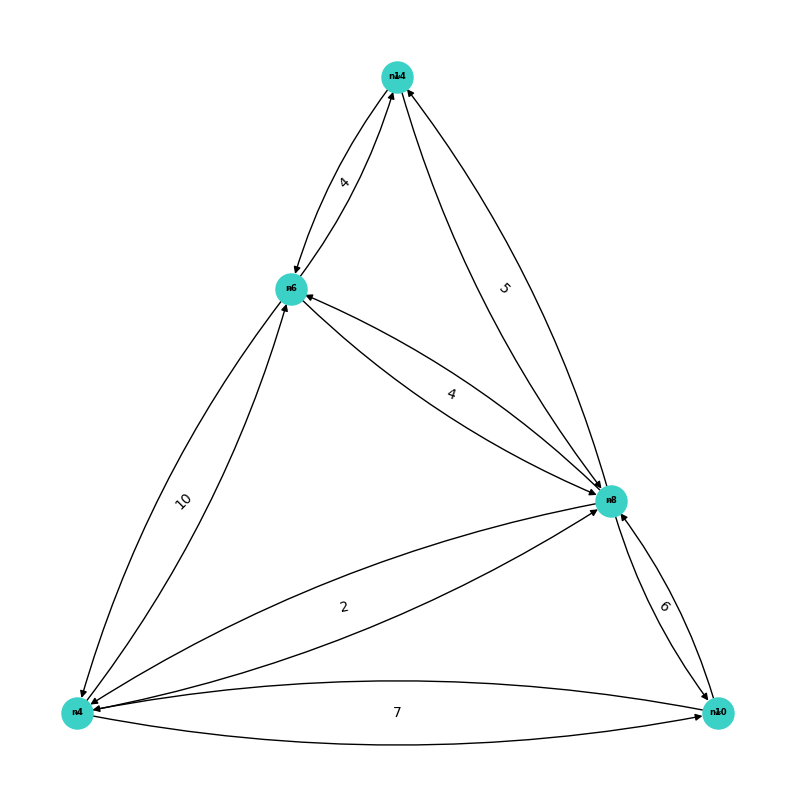

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
#-------------------------------------------------------helper functions from previous lab------------------------------------------------------------------#
def Init_Graph(Nodes):
    #takes nodes in the list format , for example [1,3,5,7,9] and initializes a directed graph
    G = nx.MultiDiGraph()
    G.add_nodes_from(Nodes)
    return G
def Add_Node(G,Node):
    #takes an initialized graph and a node and adds the node to the graph
    G.add_node(Node)

def Add_Edges(G,Edge, Weight=1):
    #takes an initialized graph 
    #and an edge or edge list in the list of tubles(start,end) form, for example [(1,5), (7,9), (1,9)]
    #and a shared weigh, by default 1
    G.add_edges_from(Edge, weight=Weight)

def Get_Nodes(G):
    #returns the list of nodes
    return list(G.nodes)

def Get_Edges(G):
    #returns a dictionary of Edges and their weights
    #for example:{(1, 5): 3, (1, 9): 3, (7, 9): 3}
    for u,v,d in G.edges(data=True):
        print(u,v,d)
    edge_labels=dict([((u,v,),d['weight'])
                 for u,v,d in G.edges(data=True)])
    return edge_labels

def Get_Out_Nodes(G,Node):
    #return a list of all the directly connected nodes out from a given node, for example [3,5]
    #the directly connected nodes [A,B] , mean that there is an edge starts from 'A' and ends at 'B'
    #i.e the incoming nodes towards 'Node' are not listed here
    #if there isnt any, the list will be empty []
    return list(G.adj[Node])

def Get_Out_Edges(G,Node):
     #return a dictionary of all the directly connected edges out from a given node and their weights
    nodeslist=Get_Out_Nodes(G,Node)
    edgesdic={}
    edge_labels=Get_Edges(G)
    for item in nodeslist:
        edgesdic[((Node,item))]=edge_labels[(Node,item)]
    return edgesdic

def Print_Graph(G):
    #takes a graph and a list of red edges
    plt.figure(figsize=(10,10))
    pos = nx.planar_layout(G, 14)
    nx.draw_networkx_nodes(G, pos, node_size= 10)
    nx.draw_networkx_labels(G, pos,font_weight='bold', font_size=3)
    edge_labels=dict([((u,v,),d['weight']) for u,v,d in G.edges(data=True)])
    nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
    nx.draw(G,pos, with_labels=True, font_weight='bold',edge_color='black',arrowsize=10,
            node_color='#3bd1c7', node_size=500, font_size=6, font_color='black', connectionstyle="arc3,rad=0.1")
    # plt.savefig("filename.png")

def construct_graph_example():
    G1=Init_Graph(['n4','n6','n8','n10','n14'])
    # Add_Node(G1,'jyjyry4')
    Add_Edges(G1,[('n8','n4'),('n4','n8')],2)
    Add_Edges(G1,[('n6','n8'),('n8','n6'), ('n6','n14'),('n14','n6')],4)
    Add_Edges(G1,[('n8','n10'),('n10','n8')],6)
    Add_Edges(G1,[('n8','n14'),('n14','n8')],5)
    Add_Edges(G1,[('n6','n4'),('n4','n6')],10)
    Add_Edges(G1,[('n4','n10'),('n10','n4')],7)
    Print_Graph(G1)
    print("The graph nodes are ", type(Get_Nodes(G1)), Get_Nodes(G1))
    print("List of edges:", type(Get_Edges(G1)),Get_Edges(G1))
    print("Example of function Get_Out_Nodes with node n6", Get_Out_Nodes(G1,'n6'))
    print("Example of function Get_Out_Edges with node n6",Get_Out_Edges(G1,'n6'))
    return G1
G1=construct_graph_example()

In [27]:
# !pip install git+https://github.com/VenkateshwaranB/stellargraph.git

14728.37s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  Cloning https://github.com/VenkateshwaranB/stellargraph.git to /tmp/pip-req-build-fjzzap_p
  Running command git clone --filter=blob:none --quiet https://github.com/VenkateshwaranB/stellargraph.git /tmp/pip-req-build-fjzzap_p
  Resolved https://github.com/VenkateshwaranB/stellargraph.git to commit efa1f847109a4ba490e7a5105646a20ee09a3243
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 2.2 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 2.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 KB 1.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 KB 1.4 MB/s eta 0:00:0000:0100:01
  Created wheel for stellargraph: filename=stellargraph-1.3.0b0-py3-none-any.whl size=431873 sha256=e9fabaec1f8a0faec369b0788044209cfe8ee0a3b955be6d1031cd004aa756c8
  Stored in directory: /tmp/pip-ephem-wheel-cache-ntqa3xf9/wheels/f3/06/0f/089f69af27d308

In [28]:
from graph_embeddings.algorithms import StackedNode2Vec

g1 = nx.DiGraph()
g2 = nx.DiGraph()
g1.add_edges_from([("A", "B"), ("B", "C"), ("C", "B"), ("B", "E")])
g2.add_edges_from([("A", "B"), ("B", "D"), ("D", "C"), ("C", "D")])

graphs = [g1, g2]
embedding_model = StackedNode2Vec()
embedding_model.fit(graphs)

embedding_model.get_embeddings()  # ndarray with shape (2, 5, 128) - graphs, nodes, embedding_size
embedding_model.get_dense_embeddings()  # ndarray with shape (2, 640) - graphs, nodes*embedding_size

2024-05-06 05:00:41.622079: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 05:00:43.424964: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-06 05:00:43.425292: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-05-06 05:00:58.151671: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

100%|██████████| 2/2 [00:05<00:00,  2.64s/it]


array([[-0.03356139, -0.00661832,  0.12465242, ..., -0.01132983,
        -0.0908731 ,  0.01156453],
       [-0.03702914, -0.0272414 ,  0.12824215, ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
def get_weight_string(string):
    weight = 0
    for s in string:
        weight += ord(s)
    return weight

In [7]:
import networkx as nx
from graph_embeddings.algorithms import StackedNode2Vec


G=nx.MultiDiGraph()

G1 = nx.MultiDiGraph()
G1.add_edge(1,2,weight=1)

G.add_edge(1,2,weight=1)
G.add_edge(1,2,weight=2)
G.add_edge(1,2,weight=3)
# G.add_edge(2,3,weight=0)
# G.add_edge(2,3,weight=1)
# G.add_edge(2,3,weight=2)
# G.add_edge(3,4,weight=0)
# G.add_edge(3,5,weight=1)
# G.add_edge(3,6,weight=2)
# G.add_edges_from([(4, 5, dict(weight=282)), (4, 5, dict(weight=37))])
# Print_Graph(G)
print(G.edges)
# print("All edges with key 2:",
#       [(i, j, k)   for i, j, k in G.edges if k == 2])
# print("All nodes connected to edges with key 2:",
#       set( [n for i, j, k in G.edges if k == 2  for n in [i, j]] ))
# Get_Edges(G)

graphs = [G, G]
embedding_model = StackedNode2Vec()
embedding_model.fit(graphs)

#For Example:
#edges with key=2
#(1,2)
#(2,3)
#(3,6)
#Nodes linked to edges with key=2
#1,2,3,6


[(1, 2, 0), (1, 2, 1), (1, 2, 2)]
100%|██████████| 2/2 [00:02<00:00,  1.40s/it]


In [8]:
G3 = embedding_model.fit([G])
G4 = embedding_model.fit([G1])

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


In [12]:
print(len(G4.get_embeddings()))

1


In [38]:
distance = np.linalg.norm(G1.get_dense_embeddings() - G2.get_dense_embeddings(), axis=1)
print(distance)

[0.]


In [9]:
np.size(embedding_model.get_dense_embeddings())

512

In [8]:
np.shape(embedding_model.get_dense_embeddings())

(2, 256)

In [12]:
import numpy as np

# centroids = np.array([[3,44],[5,15]])
# dataPoints = np.array([[2,4],[17,4],[45,2],[45,7],[16,32],[32,14],[20,56],[68,33]])
e = embedding_model.get_dense_embeddings()
distance = np.linalg.norm(e - np.array(e), axis=1)
print(distance)
# def size(vector):
#     return np.sqrt(sum(x**2 for x in vector))

# def distance(vector1, vector2):
#     return size(vector1 - vector2)

# def distances(array1, array2):
#     return [distance(vector1, vector2) for vector2 in array2 for vector1 in array1]

# print(distances(e, e))

[0. 0.]


Delete boolean_operator {'weight': 'boolean_operator'}
Delete and {'weight': 'boolean_operator'}
Delete identifier {'weight': 'boolean_operator'}
Delete or {'weight': 'boolean_operator'}
Delete unary_operator {'weight': 'boolean_operator'}
Insert boolean_operator {'weight': "'or'"}
Insert boolean_operator {'weight': "'- 1'"}
Insert not_operator {'weight': "'not'"}


{('Delete', 'boolean_operator'): 'boolean_operator',
 ('Delete', 'and'): 'boolean_operator',
 ('Delete', 'identifier'): 'boolean_operator',
 ('Delete', 'or'): 'boolean_operator',
 ('Delete', 'unary_operator'): 'boolean_operator',
 ('Insert', 'boolean_operator'): "'- 1'",
 ('Insert', 'not_operator'): "'not'"}

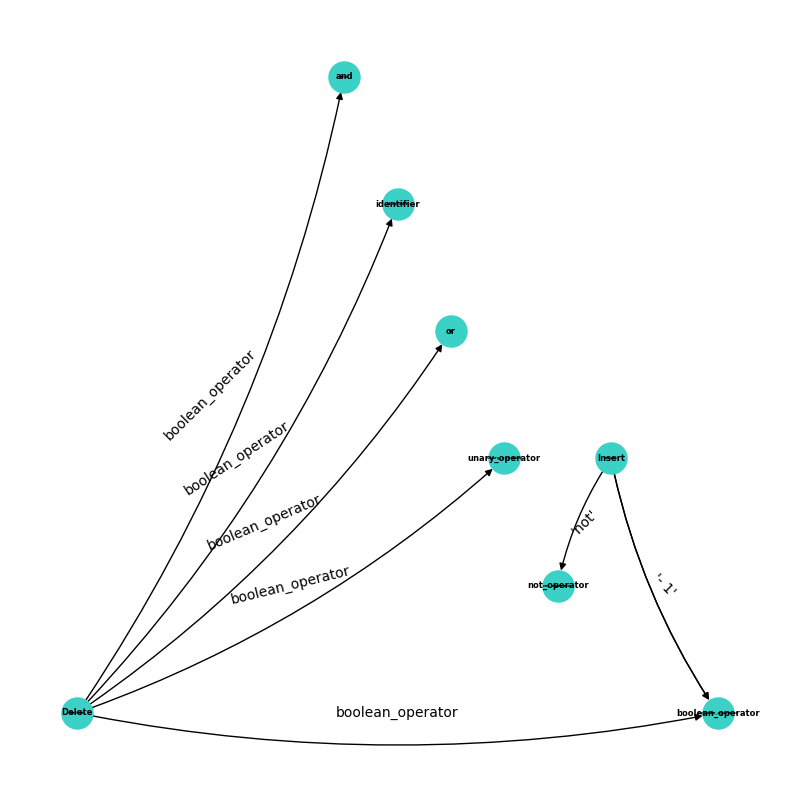

In [26]:
import re
# print(actions)
def get_within_square_brackets(text):
    pattern = r'\[(.*?)\]'
    matches = re.findall(pattern, text)
    return matches

G1 = Init_Graph([])
for action in actions:
    singleEdit = get_within_square_brackets(action[1][0])
    # print(singleEdit)
    executedAction = singleEdit[0]
    G1.add_node(singleEdit[0])

    if (executedAction == 'Insert'):
        
        G1.add_node(singleEdit[1])
        G1.add_edge(singleEdit[0], singleEdit[1], weight=singleEdit[2])
        # G1.add_node(singleEdit[3])
        # Add_Edges(G1, [(singleEdit[0], singleEdit[1])], singleEdit[2])
    elif (executedAction == 'Delete'):
        G1.add_node(singleEdit[2])
        G1.add_edge(singleEdit[0], singleEdit[1], weight=singleEdit[2])
        # G1.add_node(singleEdit[3])
        # Add_Edges(G1, [(singleEdit[0], singleEdit[2])], singleEdit[1])
    elif (executedAction == 'Update'):
        G1.add_node(singleEdit[2])
        # G1.add_node(singleEdit[3])
        G1.add_edge(singleEdit[0], singleEdit[2], singleEdit[1])

# pos=nx.spring_layout(G1,seed=5)
Print_Graph(G1)
Get_Edges(G1)


# Bleu

In [24]:
# from nltk.translate.bleu_score import sentence_bleu
# reference = data[111]["before"].split()
# # reference = [['this', 'is', 'a', 'test'], ['this', 'is' 'test']]
# # candidate = ['this', 'is', 'a', 'gteet']
# candidate = data[111]["after"].split()
# score = sentence_bleu(reference, candidate, weights= [1])
# print(score)

ModuleNotFoundError: No module named 'nltk'

In [ ]:
# from keyword import iskeyword
# string_test = "except XMPPError : log . debug ( 'Could not retrieve vCard for %s' % jid )"

# keyword_index = 0
# attribute_index = 0

# splitted = string_test.split()
# for i, s in enumerate(splitted):
#     if iskeyword(s):
#         splitted[i]
#         print(s)

except
not
for


In [ ]:
# import code_tokenize as ctok
# # from tokenizer import tokenize
# from nltk.tokenize import word_tokenize  
# tok = word_tokenize(string_test)
# # res = tokenize(string_test)
# # res2 = []
# # for r in res:
# #     print(r.txt)
# #     res2.append(r)
# # res3 = " ".join(res2)
# res = " ".join(tok)
# print(tok)

['except', 'XMPPError', ':', 'log', '.', 'debug', '(', "'Could", 'not', 'retrieve', 'vCard', 'for', '%', 's', "'", '%', 'jid', ')']


In [ ]:
from inspect import currentframe, getframeinfo
frameinfo = getframeinfo(currentframe()); locals()['a7a'] = (frameinfo.lineno); print(locals())
print((locals()['a7a']))

2


In [ ]:
print(locals()['a7a'].lineno)

2
